In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
from stl import mesh
import matplotlib.pyplot as plt

In [2]:
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [3]:
def get_coords(multiplication_factor,t_slab_x,t_slab_y,t_slab_z):
    x_size,y_size,z_size = t_slab_x/multiplication_factor,t_slab_y/multiplication_factor,t_slab_z
    coordinates_slabs=[]
    for i in range(multiplication_factor):
        for j in range(multiplication_factor):
            center_x = (i - ( multiplication_factor/ 2) + 0.5) * x_size
            center_y = (j - ( multiplication_factor/ 2) + 0.5) * y_size
            center_z = 0  # All cubes are centered on the z=0 plane
            coord_item = {
                    "X": (center_x - x_size/2, center_x + x_size/2),
                    "Y": (center_y - y_size/2, center_y + y_size/2),
                    "Z": (-z_size/2, z_size/2),
                    "center": (center_x, center_y, center_z)
                    }
            
            coordinates_slabs+=[coord_item]

    return coordinates_slabs

In [4]:
# Function to create a solid cylinder with specified center coordinates
def create_cylinder_from_ends(top_center, bottom_center, radius):
    # Calculate height of the cylinder
    height = np.linalg.norm(np.array(top_center) - np.array(bottom_center))
    bottom_center=bottom_center

    # Calculate the vector direction of the cylinder
    axis_direction = np.array(top_center) - np.array(bottom_center)
    axis_direction /= np.linalg.norm(axis_direction) #Unitary vector to calculate rotation angle 

    # Calculate the rotation matrix to align cylinder with the given axis direction
    z_axis = np.array([0, 0, 1])
    rotation_axis = np.cross(z_axis, axis_direction)
    rotation_angle = np.arccos(np.dot(z_axis, axis_direction))
    rotation_matrix = mesh.Mesh.rotation_matrix(rotation_axis, rotation_angle)
    # Create a 4x4 identity matrix
    matrix_4x4 = np.eye(4)

    # Insert the 3x3 matrix into the top-left corner of the new matrix
    matrix_4x4[:3, :3] = np.copy(rotation_matrix)

    # Set the fourth column and fourth row for homogeneous transformation
    # The typical homogeneous transformation uses [0, 0, 0, 1] for the last row and column
    matrix_4x4[3, :3] = [0, 0, 0]  # Fourth row
    matrix_4x4[:3, 3] = [0, 0, 0]  # Fourth column
    matrix_4x4[3, 3] = 1           # Bottom-right corner remains 1

    
   
    cylinder_center = tuple((np.array(top_center) + np.array(bottom_center))/2)
    trans = td.Transformed.translation(cylinder_center[0],cylinder_center[1],cylinder_center[2])
    transformed = td.Transformed(geometry=td.Cylinder(center=(0,0,0), radius=radius, length=height),transform=trans@matrix_4x4)

    return transformed

In [5]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]

In [6]:
a = 5/3

02_Sample_600_res_L18.01_28ff_eps.h5
Configured successfully.
Simulation Parameters (wavelengths are expressed in um):
Lx: 150 Ly: 150 Lz: 38.3
lambda_range: 3.88 - 4.17 um 
lambdaw (pulse) 277.77777777777777 
lambda0 4.016064257028113 
Total runtime <= 10.0 ps 
dl (Cube Size) = 71.66669201876347 nm 
Time Steps = 19647
Grid Points = 171.208224 million
eps = 13


<Figure size 1280x960 with 0 Axes>

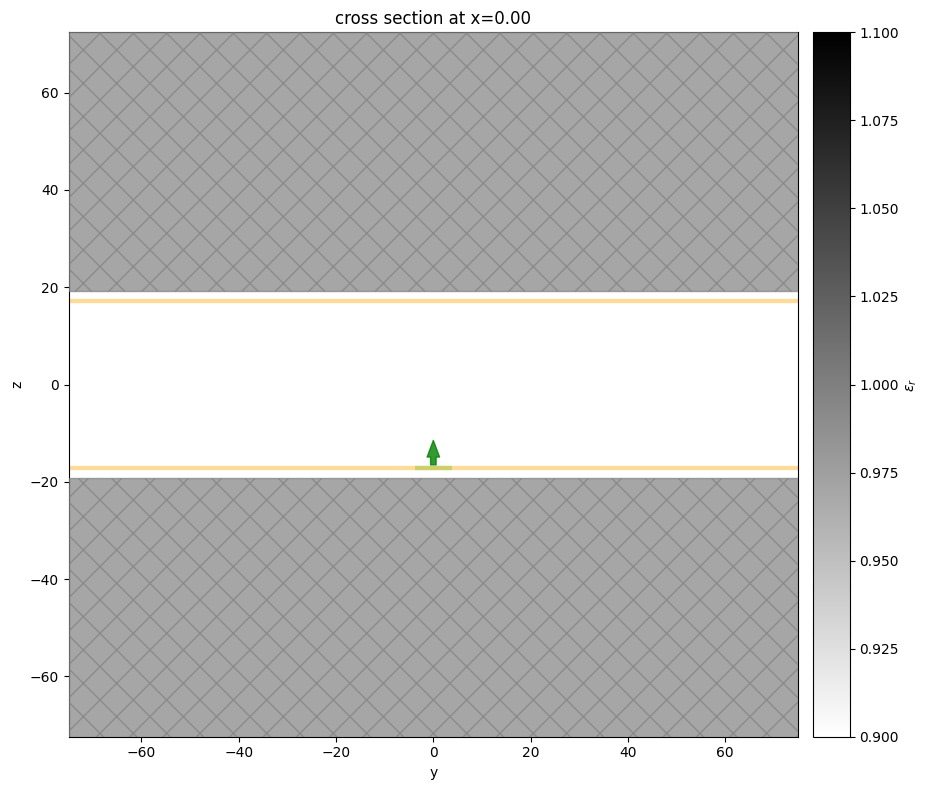

<Figure size 1600x1200 with 0 Axes>

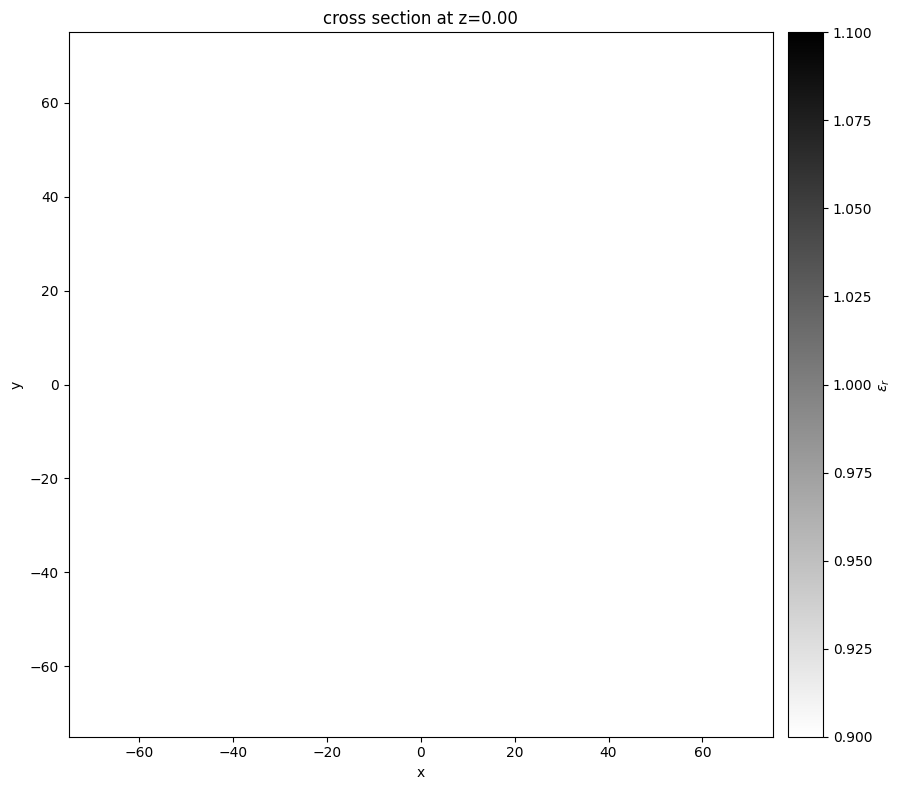

<Figure size 640x480 with 0 Axes>

In [7]:
lambdas = a/np.array([0.40,0.43]) 
folder_path = r"H:\phd stuff\tidy3d\structures\08_13_2024 Luis H5 18.01a\sample 2"
project_name = "08_19_2024 RCP Using Tidy Structures Gap Diff Perm"
postprocess_results = []
runtime_ps = 10e-12
min_steps_per_lambda = 15
for direction in ["z"]: 
    for filename in os.listdir(folder_path):
     for perm in [13]:
        print(filename)
        sim_name = f"RCP perm {perm} runtime {runtime_ps}ps nu {a/lambdas[0]} - {a/lambdas[1]}"

        if not (Path(filename).suffix==".h5" or Path(filename).suffix==".stl"):
            continue 
        if os.path.isfile(os.path.join(folder_path, filename)):
            file=os.path.join(folder_path, filename)
            structure_1 = AM.loadAndRunStructure(key = tidy3dAPI, file_path=file
                                            ,direction=direction, lambda_range=lambdas,
                                            box_size=18*a,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda, permittivity=perm,
                                           scaling=1,shuoff_condtion=1e-20, verbose=True, 
                                           monitors=["flux"], freqs=400, 
                                           cut_condition=1.0, source="tight", absorbers=200, sim_name=sim_name, use_permittivity=False, tight_percentage=0.05,
                                           ref_only=True, multiplicate_size=True,multiplication_factor=5,width=0.2
                                           )
           
            print(structure_1.__str__())
            structure_1.plot_sim_layout()

            


In [8]:
file_path =  r"H:\phd stuff\tidy3d\structures\End2EndFiles\RCP 18.01 End Points\1_sample_L18_lines_cut.dat"
data = []
with open(file_path, 'r') as file:
    for line in file: 
        row = [float(value) for value in line.split()]
        data += [np.array(row)]

data = np.array(data)

tops_centered = (data[:,:3]-0.5)*structure_1.t_slab_z
bottoms_centered = (data[:,3:]-0.5)*structure_1.t_slab_z

radius = 0.25


cyl_group = []



coords = get_coords(structure_1.multiplication_factor,structure_1.t_slab_x,structure_1.t_slab_y,structure_1.t_slab_z)


for k,coord in enumerate(coords):
    tops = np.copy(tops_centered)
    bottoms = np.copy(bottoms_centered)
    tops[:,0]+=coord["center"][0]
    tops[:,1]+=coord["center"][1]
    tops[:,2]+=coord["center"][2]
    bottoms[:,0]+=coord["center"][0]
    bottoms[:,1]+=coord["center"][1]
    bottoms[:,2]+=coord["center"][2]
    for cil,item in enumerate(tops):
         cyl_group.append(create_cylinder_from_ends(tops[cil], bottoms[cil], radius))

    
   


In [9]:
sim = structure_1.sim


In [10]:
structure_1.permittivity_value

13

In [11]:
medium=td.Medium(permittivity=structure_1.permittivity_value)
structure = td.Structure(geometry=td.GeometryGroup(geometries=cyl_group),  medium=medium)
cube = td.Structure(geometry= td.Box(
                        center=(0,  0 ,0),
                        size=(
                                structure_1.t_slab_x, 
                                structure_1.t_slab_y, 
                                structure_1.t_slab_z
                              ),
                    ),medium=td.Medium(permittivity=1))



In [12]:
boundaries= td.BoundarySpec(
            x=td.Boundary(plus=td.Absorber(num_layers=200),minus=td.Absorber(num_layers=200)),
            y=td.Boundary(plus=td.Absorber(num_layers=200),minus=td.Absorber(num_layers=200)),
            z=td.Boundary(plus=td.Absorber(num_layers=200),minus=td.Absorber(num_layers=200)),
        )
Lx, Ly, Lz =structure_1.Lx+4,structure_1.Ly+4,structure_1.Lz+10


time_monitorFieldLateral = td.FieldTimeMonitor(
                center = (0,0,0),
                size = (0,Ly,Lz),
                    start=0,
                    stop=structure_1.t_stop,
                    interval=200,
                    fields=["Ex", "Ey", "Ez"],
                    name="time_monitorFieldLateral",
                )



time_monitorT = td.FluxTimeMonitor(
                    center=[
                        (structure_1.Lx - structure_1.spacing)*0.5 if structure_1.direction == "x" else 0, 
                        (structure_1.Ly - structure_1.spacing)*0.5 if structure_1.direction == "y" else 0, 
                        (structure_1.Lz - structure_1.spacing)*0.5 if structure_1.direction == "z" else 0


                        ],
                    size=[
                        structure_1.t_slab_x,structure_1.t_slab_y,0
                        ],
                    interval = 200,
                    name="time_monitorT",

                )

In [13]:
eps_eff  = (2+structure_1.permittivity_value + 2*0.3*(structure_1.permittivity_value-1))/(2+structure_1.permittivity_value-0.3*(structure_1.permittivity_value-1))
medium=td.Medium(permittivity=eps_eff)

sim = sim.copy(update={"structures":[cube,structure],"medium":medium,'boundary_spec':boundaries,'size':[Lx,Ly,Lz],"monitors":[time_monitorT,time_monitorFieldLateral]})


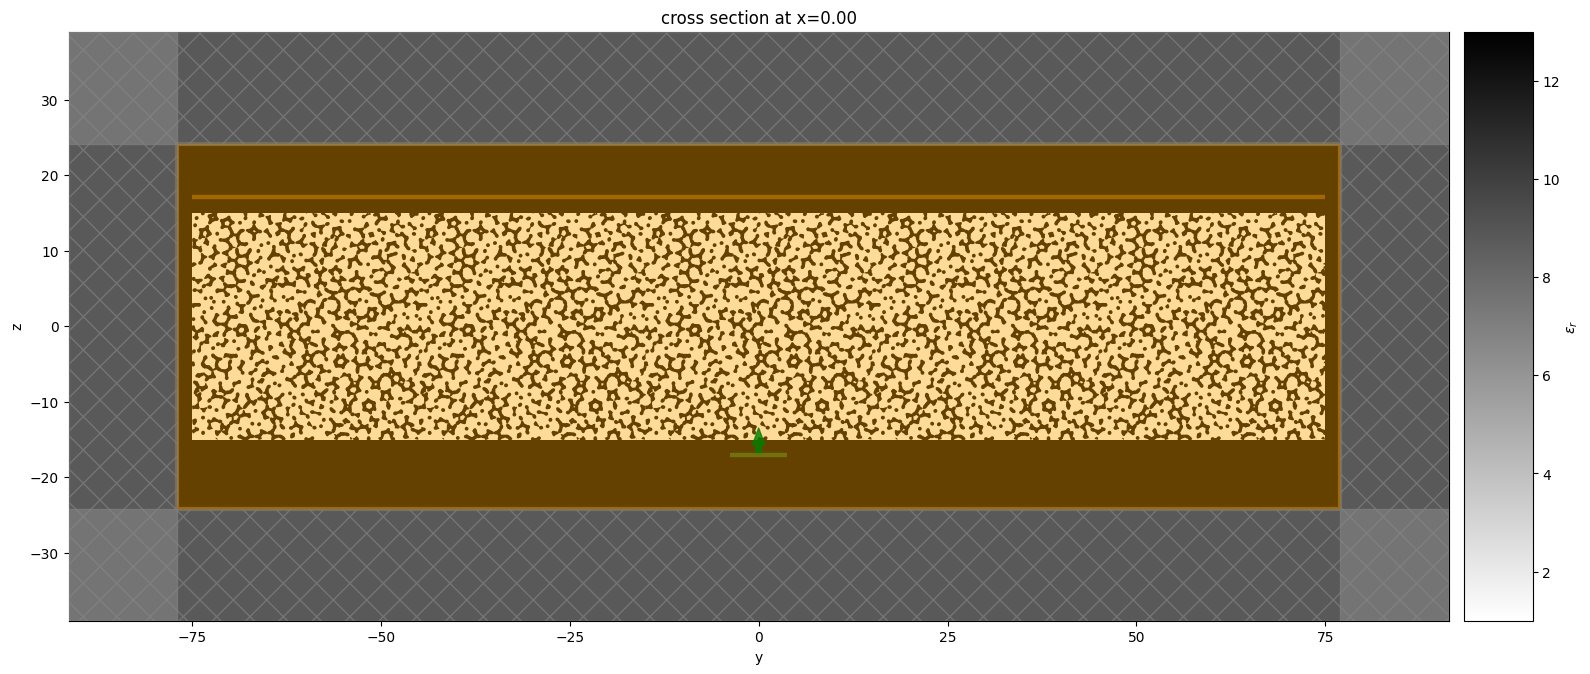

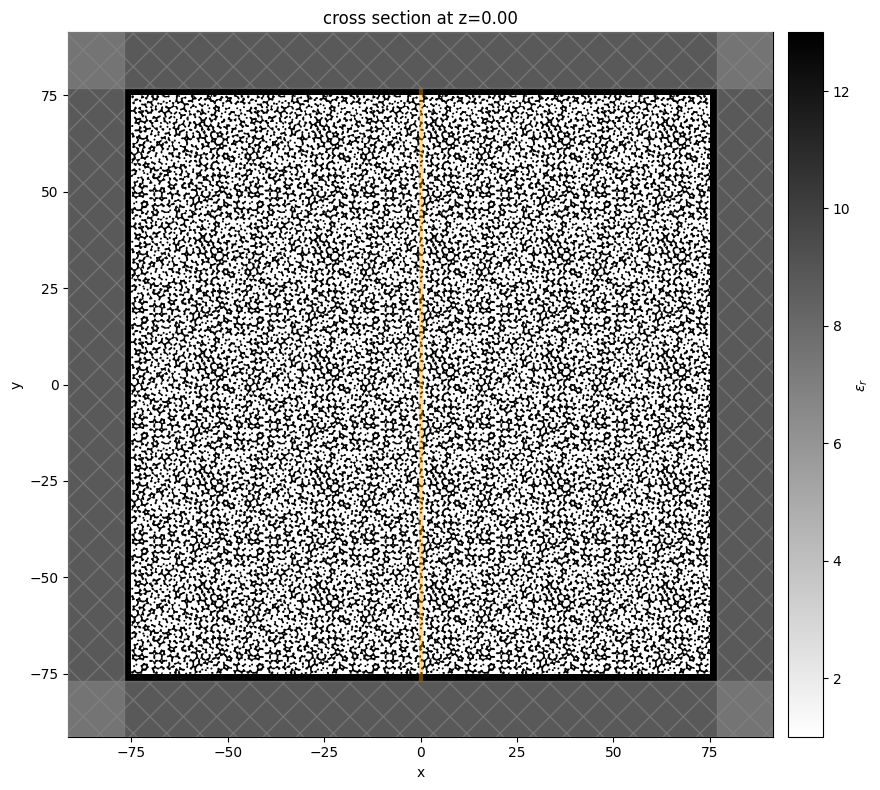

In [14]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
freqs_plot = (structure_1.freq_range[0], structure_1.freq_range[1])
sim.plot_eps(x=0, freq=freqs_plot[0], ax=ax)
#sim.plot(x=0, ax=ax)
plt.show()
fig, ax = plt.subplots(1, tight_layout=True, figsize=(16, 8))
freqs_plot = (structure_1.freq_range[0], structure_1.freq_range[1])
sim.plot_eps(z=0, freq=freqs_plot[0], ax=ax)
#sim.plot(z=0, ax=ax)
plt.show()


In [15]:
if False:
        add_ref = False
        if add_ref:
            id0 =web.upload(sim.copy(update={"structures":[],"medium":medium}), folder_name=project_name,task_name=sim_name+'_0', verbose=True)
            web.start(task_id = id0)
            web.monitor(task_id=id0,verbose=True)

        id =web.upload(sim, folder_name=project_name,task_name=sim_name, verbose=True)
        web.start(task_id = id)
        web.monitor(task_id=id,verbose=True)
    
        ids = (id0 if id0 else '') +'\n' + id
        incidence_folder = "z_incidence"
        file_path = rf"H:\phd stuff\tidy3d\data/{project_name}/{incidence_folder}/{sim_name}.txt"
        # Check if the folder exists
        if not os.path.exists( rf"H:\phd stuff\tidy3d\data/{project_name}/{incidence_folder}"):
            os.makedirs(rf"H:\phd stuff\tidy3d\data/{project_name}/{incidence_folder}")
            print(f"Folder '{project_name}/{incidence_folder}' created successfully.")

        # Open file in write mode
        with open(file_path, "w") as file:
            # Write the string to the file
            file.write(ids)